# RAG System

In [151]:
# Lets launch Milvus (you need to run Docker)
!bash standalone_embed.sh start

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wait for Milvus Starting...
Start successfully.
To change the default Milvus configuration, add your settings to the user.yaml file and then restart the service.


## Import the necessary tools

In [2]:
import os
import re
import pickle
from typing import List
from numpy import (
    ndarray,
    empty
)
from dotenv import load_dotenv

import google.generativeai as genai
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.embeddings.base import Embeddings
from langchain_milvus.retrievers import MilvusCollectionHybridSearchRetriever
from langchain_milvus.utils.sparse import BM25SparseEmbedding
from pymilvus import (
    Collection,
    CollectionSchema,
    DataType,
    FieldSchema,
    WeightedRanker,
    connections,
    utility
)
from pdfminer.high_level import extract_text
from sentence_transformers import SentenceTransformer
import umap
from tqdm import tqdm
import matplotlib.pyplot as plt

# connect to Milvus
CONNECTION_URI = "http://localhost:19530"
connections.connect(uri=CONNECTION_URI)

/root/RAG/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create MILVUS Database

In [3]:
def load_pdf_file(file_path: str, start_page: int, end_page: int) -> list:
    """
    Extracts and processes text from a specified range of pages in a PDF file.

    Parameters:
    - file_path (str): The path to the PDF file to be processed.
    - start_page (int): The page number where text extraction should begin.
    - end_page (int): The page number where text extraction should end.

    Returns:
    - list: A list of text segments (split by two newlines) extracted from the specified pages of the PDF. 
            The text is cleaned by removing content within parentheses and other formatting artifacts.
    """
    text = extract_text(file_path, page_numbers=list(range(start_page, end_page)))
    text = re.sub(r'\(.*?\)', '', text.replace('\x0c', ''), flags=re.DOTALL)
    text = text.split('\n\n')


    return text


def split_text_to_token(text_split: list) -> List[str]:
    """
    Splits a list of text segments into smaller chunks based on sentence boundaries and token limits.

    Parameters:
    - text_split (list): A list of text segments to be split into smaller chunks.

    Returns:
    - List[str]: A list of smaller text chunks, each containing no more than the defined token limit 
                 (256 tokens per chunk) with no overlapping tokens between chunks.
    """
    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)
    token_split_texts = []
    for text in [i for i in text_split if i != ""]:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts

class SentenceTransformerEmbeddings(Embeddings):
    """
    A class for generating dense embeddings for documents and queries using a SentenceTransformer model.
    
    This class provides methods to embed documents and queries, making it suitable for use in information 
    retrieval tasks. It also includes functionality to save the embedding model to a specified path.

    Args:
        model_name (str, optional): The name of the SentenceTransformer model to use for embeddings.
            Defaults to "all-MiniLM-L6-v2".

    Attributes:
        model (SentenceTransformer): The SentenceTransformer model used for encoding documents and queries.
    """
    def __init__(self, model_name:str="all-MiniLM-L6-v2"):
        """
        Initializes the SentenceTransformerEmbeddings instance with a specified SentenceTransformer model.
        
        Args:
            model_name (str, optional): The name of the SentenceTransformer model to use. 
                Defaults to "all-MiniLM-L6-v2".
        """
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, documents:list) -> list:
        """
        Generates embeddings for a list of documents.

        Args:
            documents (list of str): A list of documents to be embedded.

        Returns:
            numpy.ndarray: An array of embeddings for the provided documents.
        """
        return self.model.encode(documents)

    def embed_query(self, query:str) -> ndarray:
        """
        Generates an embedding for a single query.

        Args:
            query (str): A query to be embedded.

        Returns:
            numpy.ndarray: An embedding for the provided query.
        """
        return self.model.encode([query])[0]
    
    def save(self, path:str) -> None:
        """
        Saves the SentenceTransformer model to the specified path.

        Args:
            path (str): The path where the model should be saved.
        Returns:
            None
        """
        self.model.save(path)
    
def save_params_for_retriever(
    collection: Collection, 
    dense_field: str,
    sparse_field: str,
    dense_embedding_func: SentenceTransformerEmbeddings,
    sparse_embedding_func: BM25SparseEmbedding
    ) -> None:
    """
    Saves the parameters for setting up a Milvus hybrid retriever to a configuration file.

    Args:
        collection (Collection): The Milvus collection for which retriever parameters are being saved.
        dense_field (str): The name of the field for dense embeddings within the collection.
        sparse_field (str): The name of the field for sparse embeddings within the collection.
        dense_embedding_func (SentenceTransformerEmbeddings): The embedding function for dense text representations.
        sparse_embedding_func (BM25SparseEmbedding): The embedding function for sparse text representations.

    Returns:
        None
    """
    dense_embedding_func.save(f'src/embed_models/dense_embedding_model_{collection.name}')
    config = {
        'colection_name': collection.name,
        'dense_field': dense_field,
        'sparse_field': sparse_field,
        'sparse_embedding_func': sparse_embedding_func
    }

    with open(f"src/configs/config_params_{collection.name}.pkl", "wb") as f:
        pickle.dump(config, f)


def get_hybrid_function(
        text_field: str, 
        name_of_collection: str,
        k: int=5, 
        metric: str='IP'
    ) -> MilvusCollectionHybridSearchRetriever:
    """
    Creates and returns a MilvusCollectionHybridSearchRetriever instance, configured for hybrid search
    with both dense and sparse embeddings.

    Args:
        text_field (str): The name of the field containing text data in the Milvus collection.
        config_path (str): The path to the configuration file (in pickle format) containing collection 
            and embedding settings.
        k (int, optional): The number of top results to retrieve. Defaults to 5.
        metric (str, optional): The similarity metric to use for search (e.g., 'IP' for inner product). Defaults to 'IP'.

    Returns:
        MilvusCollectionHybridSearchRetriever: A configured hybrid search retriever for searching
            within the Milvus collection using both dense and sparse embeddings.
    """
    with open(f'src/configs/config_params_{name_of_collection}.pkl', "rb") as f:
        config = pickle.load(f)
    model = SentenceTransformerEmbeddings(f'src/embed_models/dense_embedding_model_{name_of_collection}')
    sparse_search_params = {"metric_type": metric}
    dense_search_params = {"metric_type": metric, "params": {}}
    retriever = MilvusCollectionHybridSearchRetriever(
        collection = Collection(name_of_collection),
        rerank=WeightedRanker(0.5, 0.5),
        anns_fields=[config['dense_field'], config['sparse_field']],
        field_embeddings=[model, config['sparse_embedding_func']],
        field_search_params=[dense_search_params, sparse_search_params],
        top_k=k,
        text_field=text_field,
        nprobe=20
    )

    return retriever


In [163]:
# If you need, you can delete  previous collections

collections = utility.list_collections()

# Remove each collection from the list
for collection_name in collections:
    collection = Collection(name=collection_name)
    collection.drop()
    print(f"Collection {collection_name} was remove.")

print("All of collections were remove")

Collection Tresis was remove.
All of collections were remove


In [ ]:
# Create Milvus connection schema

pk_field = "doc_id"
dense_field = "dense_vector"
sparse_field = "sparse_vector"
text_field = "text"
fields = [
    FieldSchema(
        name=pk_field,
        dtype=DataType.VARCHAR,
        is_primary=True,
        auto_id=True,
        max_length=100,
    ),
    FieldSchema(name=dense_field, dtype=DataType.FLOAT_VECTOR, dim=384),
    FieldSchema(name=sparse_field, dtype=DataType.SPARSE_FLOAT_VECTOR),
    FieldSchema(name=text_field, dtype=DataType.VARCHAR, max_length=65_535),
]

In [ ]:
# Create the collection
schema = CollectionSchema(fields=fields, enable_dynamic_field=False)
collection = Collection(
    name="Tresis", schema=schema, consistency_level="Strong"
)

In [ ]:
# Add two
dense_index = {"index_type": "FLAT", "metric_type": "IP"}
collection.create_index("dense_vector", dense_index)
sparse_index = {"index_type": "SPARSE_INVERTED_INDEX", "metric_type": "IP"}
collection.create_index("sparse_vector", sparse_index)
collection.flush()

In [ ]:
# Load split text from our pdf file
pdf_text = load_pdf_file(file_path='dataset/example.pdf', start_page=13, end_page=158)

In [ ]:
# Preprocessing text (you need to make own preprocessing for own pdf)
pdf_text = [p.replace('\n', ' ').strip() for p in pdf_text if (not re.search(r'© Springer International Publishing Switzerland 2014', p.replace('\n', ' ').strip())) and (not p.replace('\n', ' ').strip().isdigit())]
pdf_text_2 = []
for i in pdf_text:
    if i.split(' ')[0].istitle() or i.split(' ')[0] == '•':
        pdf_text_2.append(i)
    else:
        pdf_text_2[-1]+=i

chunked_text = split_text_to_token(text_split=pdf_text_2)
chunked_text_2 = []
for i in chunked_text:
    if not len(i.strip())<5:
        chunked_text_2.append(i.strip())

In [ ]:
# Create dense and sparse embedding functions
dense_embedding_func = SentenceTransformerEmbeddings()
sparse_embedding_func = BM25SparseEmbedding(corpus=chunked_text)

In [ ]:
# Insert our text to Milvus Database
entities = []
for text in chunked_text_2:
    entity = {
        dense_field: dense_embedding_func.embed_documents([text])[0],
        sparse_field: sparse_embedding_func.embed_documents([text])[0],
        text_field: text,
    }
    entities.append(entity)
collection.insert(entities)
collection.load()

In [ ]:
# Save all database params for predict
save_params_for_retriever(
    collection=collection, 
    dense_field=dense_field, 
    sparse_field=sparse_field,
    dense_embedding_func=dense_embedding_func,
    sparse_embedding_func=sparse_embedding_func
)

## Predict our RAG

In [4]:
name_of_collection = 'Tresis'

In [5]:
# Get hybrid searh function
retriever = get_hybrid_function(
    text_field='text', 
    name_of_collection=name_of_collection
)

In [6]:
def make_rag_prompt(
        query:str, 
        relevant_passage:str
    ) -> str:
    """
    Creates a prompt for a Retrieval-Augmented Generation (RAG) model, designed to answer questions using relevant text.

    Parameters:
    - query (str): The question that the assistant needs to answer.
    - relevant_passage (str): The text passage that contains relevant information for answering the query.

    Returns:
    - str: A formatted prompt for the assistant, including the query and relevant context, structured for a friendly, non-technical response in Russian.
    """
    escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
    prompt = f"""
    Human: You are a helpful and informative bot that answers questions using text from the passage below. 
    Be sure to answer in a full sentence, exhaustively, including all relevant background information.
    However, you are speaking to a non-technical audience, so be sure to break down complex concepts and
    keep your tone friendly and accommodating.
    If the passage is not relevant to the answer, you can ignore it.
    Context is given between <context>.
    The question is given between </question>.
    Thank you!

    <context>
    {escaped}
    </context>

    <question>
    {query}
    </question>

    Assistant:
    """

    return prompt

In [7]:
def get_gpt_model() -> genai.GenerativeModel:
    """
    Initializes and returns a Generative AI model from the genai library using the Gemini API.

    This function retrieves the Gemini API key from the environment variables, configures 
    the genai library, and initializes a generative model. If the API key is not provided, 
    it raises an error.

    Returns:
        genai.GenerativeModel: An instance of the generative model configured with the 'gemini-pro' model name.

    Raises:
        ValueError: If the Gemini API key is not set in the environment variables as GEMINI_API_KEY.
    """
    load_dotenv()
    gemini_api_key = os.getenv("GEMINI_API_KEY")
    if not gemini_api_key:
        raise ValueError("Gemini API Key not provided. Please provide GEMINI_API_KEY as an environment variable")
    genai.configure(api_key=gemini_api_key)
    model = genai.GenerativeModel('gemini-pro')

    return model

In [8]:
def generate_answer_prompt(
        query:str, 
        retriever:MilvusCollectionHybridSearchRetriever, 
        model:genai.GenerativeModel
    ) -> str:    
    """
    Generates an answer to a query by using a retrieval-based prompt and a generative model.

    Parameters:
    - query (str): The question that the assistant should answer.
    - retriever (MilvusCollectionHybridSearchRetriever): The retriever object used to fetch relevant documents for the query.
    - model (genai.GenerativeModel): The generative model used to generate the answer based on the prompt.

    Returns:
    - str: The model's generated answer in response to the query, based on the provided relevant context.
    """
    similar_docs = retriever.invoke(query)
    relevant_text = ". ".join([doc.page_content.capitalize() for doc in similar_docs])
    prompt = make_rag_prompt(query=query, relevant_passage=relevant_text)
    answer = model.generate_content(prompt)
    
    return answer.text

In [9]:
# Get predict from our questoin
model = get_gpt_model()
query="What factors do examiners consider when evaluating a thesis, and how do they use examiner reports to improve the quality of the candidate’s work?"
answer = generate_answer_prompt(query=query, model=model, retriever=retriever)
answer

"Examiners consider several factors while evaluating a thesis, such as whether it is a careful, rigorous, and sustained piece of work and if it demonstrates that the candidate is knowledgeable in their field. Examiners also use examiner reports to improve the quality of the candidate's work by providing feedback on the candidate's thesis and identifying areas where the candidate can improve."

In [ ]:
# If you need, you can remove collection 

collection.drop()

## Visualization

In [136]:
def project_embeddings(embeddings: list, umap_transform: umap.UMAP) -> ndarray:
    """
    Projects a list of high-dimensional embeddings into a 2D space using a pre-trained UMAP transformer.

    Parameters:
    - embeddings (list): A list of high-dimensional embedding vectors to be projected.
    - umap_transform (umap.UMAP): A pre-trained UMAP transformer used to reduce the dimensionality of embeddings.

    Returns:
    - np.ndarray: A 2D NumPy array containing the projected embeddings with shape (n_samples, 2).
                  Each row represents the 2D coordinates of the corresponding input embedding.
                  
    Notes:
    - This function assumes that `umap_transform` has been fit previously with similar embeddings.
    - The transformation is performed one embedding at a time, which may be slower but avoids issues with 
      differing embedding shapes or sizes.
    """
    umap_embeddings = empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
        
    return umap_embeddings  

In [ ]:
# Load dence embedding model
model = SentenceTransformerEmbeddings(f'src/embed_models/dense_embedding_model_{name_of_collection}')
# Get relevant text embeddings
embed_ret = [model.model.encode(i.page_content) for i in retriever.invoke(query)]
# Get all collection embeddings
embed_all = [retriever.field_embeddings[0].embed_documents([i['text']])[0] for i in retriever.collection.query(expr="doc_id >= '0'", output_fields=['text'])]
# Get your query embedding
embed_query = model.model.encode(query)
# Get RAG answer embedding
embed_answer = model.model.encode(answer)

# Get UMAP model trained on all collection embeddings
umap_transform_all = umap.UMAP(random_state=0, transform_seed=0).fit(embed_all)

# Get Arrays of UMAP model point for visualization
projected_dataset_embeddings = project_embeddings(embed_all, umap_transform_all)
projected_query_embedding = project_embeddings([embed_query], umap_transform_all)
projected_answer_embedding = project_embeddings([embed_answer], umap_transform_all)
projected_retrieved_embeddings = project_embeddings(embed_ret, umap_transform_all)

/root/RAG/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 5/5 [00:00<00:00, 90.30it/s]


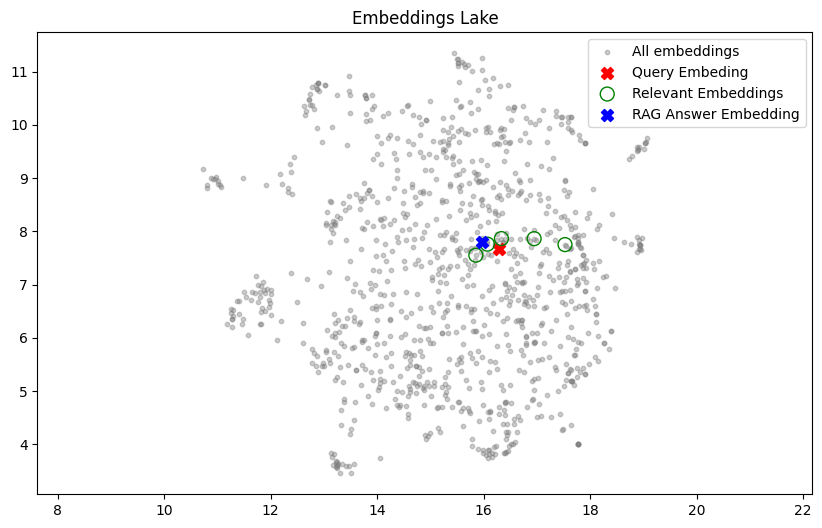

In [142]:
# Create scatter plots

plt.figure(figsize=(10, 6))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', alpha=0.4, label='All embeddings')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=75, marker='X', color='r', label='Query Embeding')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Relevant Embeddings')
plt.scatter(projected_answer_embedding[:, 0], projected_answer_embedding[:, 1], s=75, marker='X', color='blue', label='RAG Answer Embedding')
plt.legend()
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings Lake')
plt.show()

In [153]:
# Stop Milvus container

!bash standalone_embed.sh stop

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Stop successfully.
